In [7]:
import pandas as pd
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.cluster import AgglomerativeClustering
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
import numpy as np
from sklearn.cluster import AgglomerativeClustering
import seaborn as sns
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier
from scipy.cluster.hierarchy import dendrogram, ward
from sklearn.feature_extraction import text
from sklearn.metrics.pairwise import cosine_similarity
from pylab import rcParams
rcParams['figure.figsize'] = 50, 20
import nltk
from nltk.corpus import stopwords
import re
import time
start=time.time()
nltk.download('stopwords')
%matplotlib inline
import warnings; warnings.simplefilter('ignore')
from statistics import mean 

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\pvali\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [8]:
# Functions to clean skills data and make a vocabulary for skills vectorization
common_placeholders = [
    'see job description', 'n/a', 'not applicable', 'none', 'no skills required', 
    'please see job description', 'refer to job description'
]

def text_scrubber(values):
    result = []
    for item in values:
        # If 'item' is a list or an array, handle it appropriately
        if isinstance(item, list) or isinstance(item, np.ndarray):
            item = ', '.join([str(i) for i in item])  # Convert list/array to string
        # Now 'item' should be a string, handle NaN values and strings
        if pd.isna(item):
            result.append('')
        else:
            # Your existing cleaning code
            temp = item.lower()  # Convert to lowercase
            temp = re.sub(r'\(.*\)|&#39;|\x92', '', temp)  # Remove unwanted characters
            temp = re.sub(r' &amp; |&amp;|\x95|:|;|&|\.|/| and ', ',', temp)  # Replace certain characters with comma
            temp = re.sub(r'\s+', ' ', temp).strip()  # Normalize white spaces
            # Optionally, split the skills into a list and remove empty entries
            temp = [skill.strip() for skill in temp.split(',') if skill.strip()]
            # Rejoin the cleaned skills into a string separated by commas
            temp = ','.join(temp)
            result.append(temp)
    return result

def tokenizer(df):
    
    # Custom stop words that come up very often but don't say much about the job title.
    stops = ['manager', 'nice' 'responsibilities', 'used', 'skills', 'duties', 'work', 'worked', 'daily', 'next','magic','world','interview',
             'services', 'job', 'good','using', '.com', 'end', 'prepare', 'prepared', 'lead', 'requirements','#39','see below','yes','null'] + list(stopwords.words('english'))
    values, ids, resume_ids = [],[],[]
    count = 0
    for idx, row in df.iterrows():        
        # Split on commas
        array = row['skills']
        array=str(array)
        array=array.split(',')
        for x in array:
            # make sure the value is not empty or all numeric values or in the stop words list
            if x != '' and not x.lstrip().rstrip() in stops and not x.lstrip().rstrip().isdigit():
                # make sure single character results are the letter 'C' (programming language)
                if len(x) > 1 or x == 'C':
                    # drop stuff > 4 gram
                    if len(x.split(' ')) <= 4:
                        # update lists
                        values.append(x.lstrip().rstrip())
                        ids.append(count)
                        count+=1
    
    # New dataframe with updated values.
    result_df = pd.DataFrame()
    result_df['skills'] = values
    print(result_df)
    return result_df

#df = pd.read_csv("../../data/dice-shortened.csv")
#df = pd.read_csv("../karim/jobs_to_upload.csv")
df = pd.read_json("../karim/jobs.json")
print(df)


                                  uid  \
0    e693e54c399647fd811624e3a10a71b3   
1    79c78e926cfb48cebc1b31c77c120d35   
2    7c70defce448477ea96cf65ce223e315   
3    dcf33748a8114c1e8285ab73e03598c4   
4    8f36dd0f435a4b9bb94e45f714dc4d29   
..                                ...   
603  c2bacd0c1d8a4e0bbea7b0dddf73ab96   
604  0002cb7c47694a7fa4b668de57a38036   
605  ff1a6880006b42ca93ad66be23554576   
606  835da127d056423e95c7f73c65296c06   
607  e88e8e3d39e34cc6856b1cc31a63eb41   

                                                 title  \
0                                  developer, software   
1                       Intermediate Software Engineer   
2                            Software Engineer in Test   
3             Java Software Developer (Work from home)   
4                           Software/Firmware Engineer   
..                                                 ...   
603                         Senior Azure Data Engineer   
604                       Senior C++ Softwa

In [9]:
df['skills'] = text_scrubber(df['skills'])
print(df['skills'])
#df['skills'].to_csv("skills_test.csv", index=False)

0                                                       
1      postgresql,sql,aws,spring,clean,azure,s,react,...
2                                            s,java,play
3               mysql,sql,ajax,s,javascript,mariadb,java
4                                           c++,python,c
                             ...                        
603       sql,scala,play,r,agile,ml,spark,s,azure,python
604        net,java,c,agile,c++,javascript,s,node,js,aws
605    oracle,sql,java,spring,postgresql,azure,aws,mysql
606    sql,oracle,react,java,agile,angular,s,azure,ja...
607              tensorflow,pytorch,go,ml,spark,s,python
Name: skills, Length: 608, dtype: object


In [10]:
#df.to_csv("df.csv", index=False)
test_df = tokenizer(df)
#test_df.to_csv("test_df.csv", index=False)

          skills
0     postgresql
1            sql
2            aws
3         spring
4          clean
...          ...
2648     pytorch
2649          go
2650          ml
2651       spark
2652      python

[2653 rows x 1 columns]


In [11]:
voc = test_df['skills'].unique()
print(voc)

['postgresql' 'sql' 'aws' 'spring' 'clean' 'azure' 'react' 'angular' 'vue'
 'js' 'java' 'play' 'mysql' 'ajax' 'javascript' 'mariadb' 'c++' 'python'
 'agile' 'css' 'typescript' 'html' 'net' 'salesforce' 'serverless' 'sas'
 'vb' 'bash' 'django' 'oracle' 'linux' 'redis' 'powershell' 'lift' 'rust'
 'android' 'pytorch' 'tensorflow' 'ml' 'lua' 'ruby' 'mainframe' 'rexx'
 'wordpress' 'cuba' 'catalyst' 'self' 'shell' 'ios' 'kotlin' 'node'
 'swift' 'xslt' 'go' 'sqlite' 'cordova' 'firebase' 'hive' 'spark' 'flink'
 'abap' 'apex' 'php' 'cassandra' 'scala' 'assembly' 'avenue' 'bc' 'watson'
 'express' 'couchdb' 'flex' 'sharepoint' 'laravel' 'asp' 'flask'
 'coldfusion' 'puppet' 'inform' 'struts' 'designer' 'opa' 'cobol'
 'elasticsearch' 'drupal' 'hadoop' 'pilot' 'symfony' 'io' 'groovy' 'arc'
 'logo' 'phoenix' 'xen' 'yarn' 'arduino' 'ninja' 'perl' 'forth' 'matlab'
 'universe' 'simulink' 'lithium' 'verilog' 'storm' 'icon' 'signal'
 'labview' 'teradata' 'vhdl' 'tcl' 'automator' 'opencl']


In [12]:
import pandas as pd

# Read the CSV file
#df = pd.read_csv("../../data/dice-shortened.csv")
#df = pd.read_csv("../karim/jobs_to_upload.csv")
#df = pd.read_json("../karim/jobs_to_upload.json")

# Define a function to clean the text in each job description
def clean_text(text):
    cleaned_text = text.replace("&nbsp;", " ").replace("\x92", " ").replace("\x95", " ").replace('&amp;', " ") \
        .replace('*', " ").replace(".", " ").replace("co&#39;s", "").replace("\xae&quot;", "") \
        .replace("&#39;s", "").replace("&quot;", "").replace("?", "").replace("&#39;s", "") \
        .replace("@", "").replace("\x96", "")
    return cleaned_text

# Apply the clean_text function to each element in the 'jobdescription' column
df['desc'] = df['desc'].apply(clean_text)
print(df['desc'])
df['desc'].to_csv("jobdesc_test.csv", index=False)

0        education: college/cegep experience: experie...
1            for more than 20 years, pointclickcare h...
2          who are we  amaris consulting is an indepe...
3      at avantune we are helping company to improve ...
4      we are seeking an software engineer who has ex...
                             ...                        
603      overview:    attention seasoned data profess...
604     about the role:   at morningstar, helping inv...
605    kingswaysoft is currently looking to add a cou...
606     senior qa engineer  we are seeking a highly m...
607      about the job:       do you want to design a...
Name: desc, Length: 608, dtype: object


In [13]:
#min_df ignores terms that are in more than 20% of documents
mine = ['manager', 'amp', 'nbsp', 'responsibilities', 'used', 'skills', 'duties', 'work', 'worked', 'daily','services', 'job', 'using', 'com', 'end', 'prepare', 'prepared', 'lead', 'requirements','summary','Job Role','Position']
vec = TfidfVectorizer(analyzer='word', ngram_range=(1, 2), token_pattern='[a-zA-z]{3,50}', max_df=0.2, min_df=2, max_features=10000, stop_words=list(text.ENGLISH_STOP_WORDS.union(list(mine))), decode_error='ignore', vocabulary=None, binary=False)

In [14]:

df['desc_new']=df['desc']+df['title']
df.to_csv("desc_new.csv", index=False)
description_matrix2 = vec.fit_transform(df['desc_new'].values.astype('U'))
description_matrix2 = pd.DataFrame(description_matrix2.todense())
description_matrix2.columns = vec.get_feature_names_out()

In [306]:
description_matrix2.to_csv("description_matrix.csv", index=False)

In [15]:
#uses only vocab set made above for vectorization
vec2 = TfidfVectorizer(vocabulary=voc, decode_error='ignore')
df['skills_new']=df['skills']
skills_matrix2 = vec2.fit_transform(df['skills_new'].values.astype('U'))
skills_matrix2 = pd.DataFrame(skills_matrix2.todense())
skills_matrix2.columns = vec2.get_feature_names_out()

In [308]:
skills_matrix2.to_csv("skills_matrix.csv", index=False)

In [16]:
jobtitle_matrix = pd.concat([skills_matrix2, description_matrix2], axis=1)
jobtitle_matrix

,postgresql,sql,aws,spring,clean,azure,react,angular,vue,js,...,york application,young,youth,youtube,yrs,zaporizhia,zaporizhia regions,zero,zoho,zone
0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.389051,0.213955,0.240461,0.343149,0.310964,0.236077,0.292199,0.310964,0.414515,0.347790,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.000000,0.226947,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
603,0.000000,0.238892,0.000000,0.000000,0.000000,0.263592,0.000000,0.000000,0.000000,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
604,0.000000,0.000000,0.315876,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.456866,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
605,0.458124,0.251941,0.283153,0.404073,0.000000,0.277990,0.000000,0.000000,0.000000,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
606,0.433188,0.238228,0.267741,0.000000,0.000000,0.262859,0.325349,0.346243,0.000000,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [17]:
# Run PCA to reduce number of features
pca = PCA(n_components=600, random_state=42)
comps = pca.fit_transform(jobtitle_matrix)
print(comps)

[[-6.70419546e-02 -2.91142124e-01 -2.26940413e-01 ...  1.99217019e-17
  -2.46604655e-17 -1.13218941e-17]
 [-4.40263317e-02  2.74116363e-01 -1.51701027e-01 ... -1.67374914e-17
  -1.20853047e-17  5.59257925e-18]
 [-9.82884018e-02 -2.28251603e-01  5.05473036e-01 ...  9.52653415e-18
  -1.52598372e-17  1.01232584e-17]
 ...
 [ 6.26157990e-02  2.40151531e-01  2.25102095e-01 ...  7.84751712e-20
   7.29295542e-20 -1.39356992e-19]
 [-2.13681887e-02  4.63227682e-01  1.53608962e-01 ...  7.84751712e-20
   7.29295542e-20 -1.39356992e-19]
 [ 1.54752993e-01 -2.55723336e-01  1.88307158e-03 ...  7.84751712e-20
   7.29295542e-20 -1.39356992e-19]]


In [18]:
# Put the components into a dataframe
comps = pd.DataFrame(comps)

In [19]:
print(comps)

          0         1         2         3         4         5         6    \
0   -0.067042 -0.291142 -0.226940 -0.129288 -0.024680 -0.270806 -0.083508   
1   -0.044026  0.274116 -0.151701  0.220199  0.039764 -0.107180  0.151237   
2   -0.098288 -0.228252  0.505473  0.161177 -0.178680  0.157992 -0.297544   
3   -0.140328  0.064358  0.025847 -0.006396 -0.002361 -0.216388 -0.006845   
4    0.433939 -0.119051  0.059733  0.433310  0.212246  0.035882 -0.058136   
..        ...       ...       ...       ...       ...       ...       ...   
603  0.153552  0.060797  0.146953 -0.056274  0.372373  0.317462 -0.067457   
604 -0.256719  0.344057  0.023101  0.077908  0.036454  0.034834  0.004247   
605  0.062616  0.240152  0.225102 -0.043101  0.115873 -0.338825  0.208800   
606 -0.021368  0.463228  0.153609  0.128721  0.106235 -0.023100  0.107438   
607  0.154753 -0.255723  0.001883  0.189625  0.286013  0.259074  0.395646   

          7         8         9    ...           590           591  \
0   -

In [20]:
cltr = AgglomerativeClustering(n_clusters=8)
cltr.fit(comps)
df['cluster_no'] = cltr.labels_
X = comps
y = df['cluster_no']
X_train, X_test, y_train, y_test = train_test_split(X,y, stratify=y, random_state=42)
lr = LogisticRegression(C=10, penalty='l2', multi_class='multinomial', solver='sag', max_iter=1000)
lr.fit(X_train, y_train)
score3=lr.score(X_test, y_test)
print(score3)

0.9342105263157895


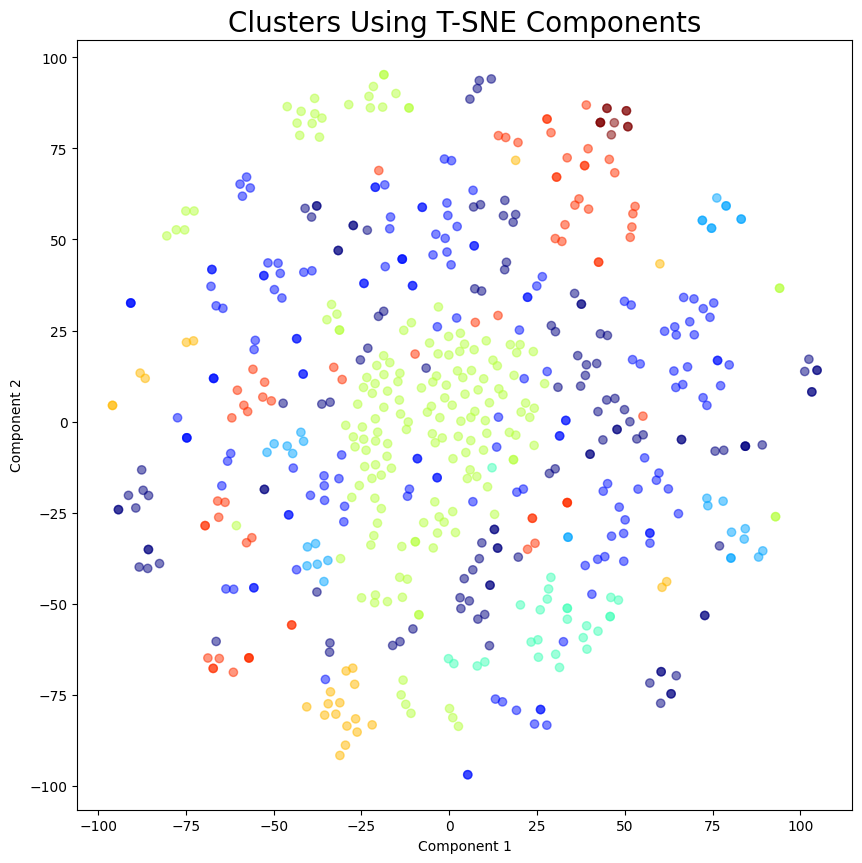

In [21]:
# Look at clusters

from sklearn.manifold import TSNE

tsne = TSNE()
g = pd.DataFrame(tsne.fit_transform(comps), columns=['one', 'two'])


g['cluster_no'] = cltr.labels_

import matplotlib.cm as cm

plt.figure(figsize=(10,10))
plt.title('Clusters Using T-SNE Components', fontsize=20)
plt.xlabel('Component 1')
plt.ylabel('Component 2')
plt.scatter(g['one'], g['two'], c=g['cluster_no'], cmap=cm.jet, alpha=0.5)

plt.show()

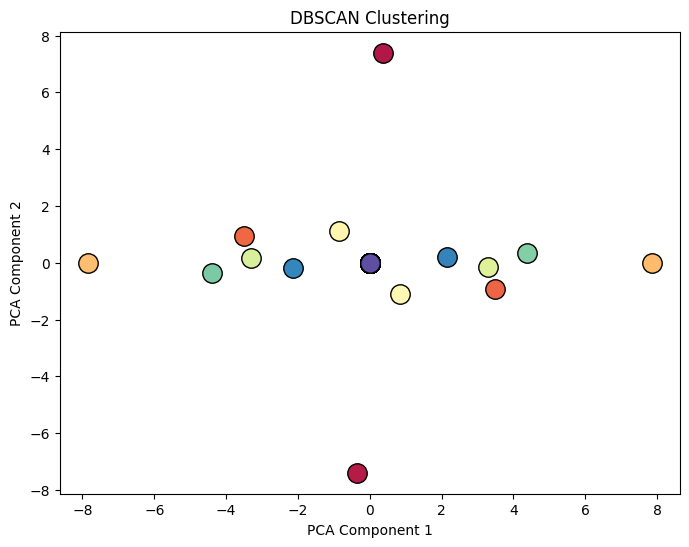

In [198]:
import matplotlib.pyplot as plt
from sklearn.cluster import DBSCAN
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
import pandas as pd

# Assuming 'data' is your DataFrame with the features you want to cluster

# Standardize features by removing the mean and scaling to unit variance
scaler = StandardScaler()
data_scaled = pd.DataFrame(scaler.fit_transform(comps))


# Perform DBSCAN clustering
dbscan = DBSCAN(eps=1, min_samples=1)  # eps and min_samples need to be chosen appropriately
clusters = dbscan.fit_predict(data_scaled)

# Perform PCA for dimensionality reduction for visualization purposes
pca = PCA(n_components=2)
data_pca = pca.fit_transform(data_scaled)

# Create a scatter plot
plt.figure(figsize=(8, 6))
unique_labels = set(clusters)  # The unique labels of clusters from DBSCAN
colors = [plt.cm.Spectral(each) for each in np.linspace(0, 1, len(unique_labels))]

for k, col in zip(unique_labels, colors):
    if k == -1:
        # Black used for noise (outliers).
        col = [0, 0, 0, 1]

    class_member_mask = (clusters == k)

    xy = data_pca[class_member_mask]
    plt.plot(xy[:, 0], xy[:, 1], 'o', markerfacecolor=tuple(col), markeredgecolor='k', markersize=14)

plt.title('DBSCAN Clustering')
plt.xlabel('PCA Component 1')
plt.ylabel('PCA Component 2')
plt.show()


In [22]:
# Assign cluster number to each job title in comps to pull particular cluster out for comparison
comps['cluster_no'] = y.values
comps.set_index('cluster_no', inplace=True)
print(comps)

In [54]:
from joblib import dump

# Save your model components
dump(vec, 'vec.joblib')
dump(vec2, 'vec2.joblib')
dump(pca, 'pca.joblib')
dump(lr, 'lr.joblib')
dump(comps, 'comps.joblib')
df.to_json('df.json')